In [1]:
import os
path = os.path.join('/home/santiago/Documents/dev/reservoirpy')
import sys
sys.path.insert(0,path)

import numpy as np
from datetime import date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.wellproductivitypy import decline as dc
import seaborn as sns

# Declination Object

Create a declination Object by setting the parameters

In [2]:
qi = 680 #bbl/d
di = 0.28 #Annual declination in fraction
ti = date(2020,5,1) #Time for initial flow
b = 0

c = dc.declination(qi=qi,di=di,ti=ti)
print(c)

Exponential Declination 
 Ti: 2020-05-01 
 Qi: 680 bbl/d 
 Rate: 0.28 Annually 
 b: 0


In [3]:
fr,cum = c.forecast(date(2020,2,1),date(2025,12,31),fq='1d')
print(fr)
print('Cummulative production is: ', np)

              rate        cum
time                         
2020-02-01  728.61     728.61
2020-02-02  728.05    1456.65
2020-02-03  727.49    2184.14
2020-02-04  726.93    2911.08
2020-02-05  726.37    3637.45
...            ...        ...
2025-12-27  139.38  768530.75
2025-12-28  139.27  768670.03
2025-12-29  139.17  768809.20
2025-12-30  139.06  768948.26
2025-12-31  138.95  769087.21

[2161 rows x 2 columns]
Cummulative production is:  <module 'numpy' from '/home/santiago/anaconda3/envs/dev/lib/python3.7/site-packages/numpy/__init__.py'>


In [4]:
c.forecast()

(              rate        cum
 time                         
 2020-05-31  664.53     664.53
 2020-06-30  649.41   20146.85
 2020-07-31  634.15   39805.48
 2020-08-31  619.25   59002.13
 2020-09-30  605.16   77156.88
 2020-10-31  590.94   95475.92
 2020-11-30  577.49  112800.70
 2020-12-31  563.92  130282.26
 2021-01-31  550.67  147353.00
 2021-02-28  538.97  162444.08
 2021-03-31  526.30  178759.41
 2021-04-30  514.33  194189.23,
 194189.23)

In [5]:
fr, cum = c.forecast(econ_limit=300, fq='1m')
print(fr)
print('Cummulative ',np)

              rate        cum
time                         
2020-05-31  664.53     664.53
2020-06-30  649.41   20146.85
2020-07-31  634.15   39805.48
2020-08-31  619.25   59002.13
2020-09-30  605.16   77156.88
2020-10-31  590.94   95475.92
2020-11-30  577.49  112800.70
2020-12-31  563.92  130282.26
2021-01-31  550.67  147353.00
2021-02-28  538.97  162444.08
2021-03-31  526.30  178759.41
2021-04-30  514.33  194189.23
Cummulative  <module 'numpy' from '/home/santiago/anaconda3/envs/dev/lib/python3.7/site-packages/numpy/__init__.py'>


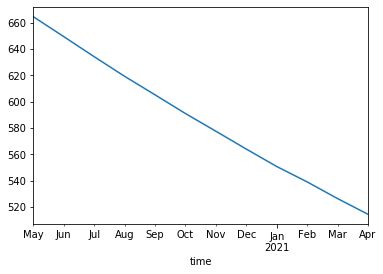

In [6]:
fr['rate'].plot()

## Fit real production data to declination

In [7]:
from sqlalchemy import create_engine

## Set up Database 
Username='scuervo'
Password='Fenicia1703'
Host='localhost'
db_name='cedco'
connect_database='postgresql://{}:{}@{}/{}'.format(Username,Password,Host,db_name)

engine = create_engine(connect_database)

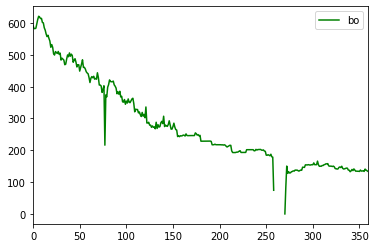

In [8]:
query = """
    select w.well, p.date, p.bo
    from production p
    join wells w on p.well_id = w.id
    where w.well = 'CANACABARE-3' and p.date >= DATE '2019-09-01'
    order by p.date
"""

prod = pd.read_sql(query,engine)
prod.head()
prod.plot(color='green')

In [9]:
prod

,well,date,bo
0,CANACABARE-3,2019-09-01,591.662488
1,CANACABARE-3,2019-09-02,582.793308
2,CANACABARE-3,2019-09-03,582.466135
3,CANACABARE-3,2019-09-04,583.804090
4,CANACABARE-3,2019-09-05,598.191882
...,...,...,...
355,CANACABARE-3,2020-08-21,133.620662
356,CANACABARE-3,2020-08-22,140.944825
357,CANACABARE-3,2020-08-23,137.843793
358,CANACABARE-3,2020-08-24,135.875024


divide by zero encountered in log
invalid value encountered in greater
invalid value encountered in greater
invalid value encountered in greater


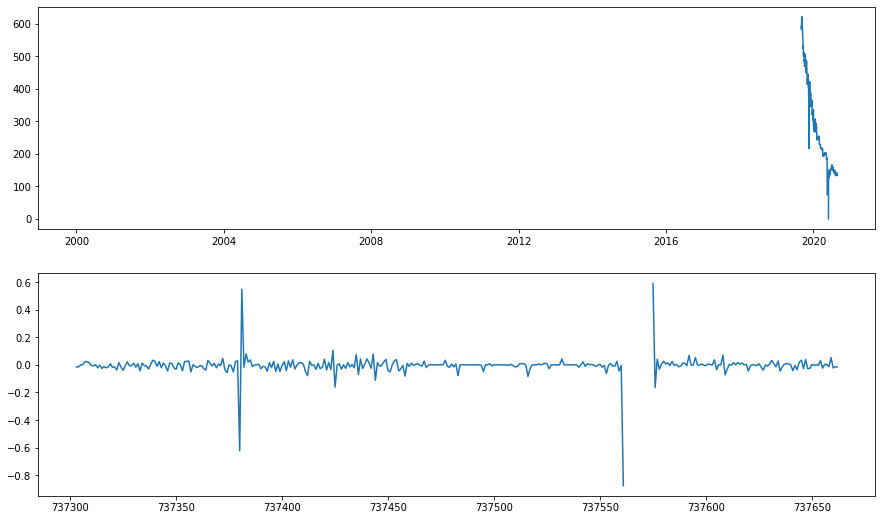

In [10]:
range_time = prod['date']
flow_rate=prod['bo']
tnum = range_time.apply(lambda x: x.toordinal()) 
lnq = np.log(flow_rate)
slp = np.diff(lnq) / np.diff(tnum)
slp = np.append(slp[0],slp)
mu = slp.mean()
sig = slp.std()
range_timef = range_time[np.abs(slp)>mu+3*sig]
flow_ratef = flow_rate[np.abs(slp)>mu+3*sig]

fig,ax = plt.subplots(2,1, figsize=(15,9))

ax[0].scatter(range_timef,flow_ratef, color='red')
ax[0].plot(range_time,flow_rate)
ax[1].plot(tnum,slp)
ax[1].scatter(tnum[np.abs(slp)>mu+3*sig],slp[np.abs(slp)>mu+3*sig])
ax[1].plot([tnum[0],tnum[-1:]],np.full(2,mu+3*sig))
ax[1].plot([tnum[0],tnum[-1:]],np.full(2,mu-3*sig))


In [11]:
c3 = dc.declination()
c3.fit(prod,time='date',rate='bo',xstd=3)
c3

Shape of input dataframe  348
Revome 4 rows by anomalies
new shape 344


Hyperbolic Declination 
 Ti: 2019-09-01 
 Qi: 618.7532944409021 bbl/d 
 Rate: 2.3873637756327684 Annually 
 b: 0.43878540285583745

In [12]:
f,cum=c3.forecast(end_date=date(2020,5,1),fq='D')
f

,rate,cum
time,,
2019-09-01,618.75,618.75
2019-09-02,614.73,1233.48
2019-09-03,610.73,1844.21
2019-09-04,606.78,2450.99
2019-09-05,602.86,3053.86
...,...,...
2020-04-27,188.17,82543.24
2020-04-28,187.44,82730.68
2020-04-29,186.72,82917.40


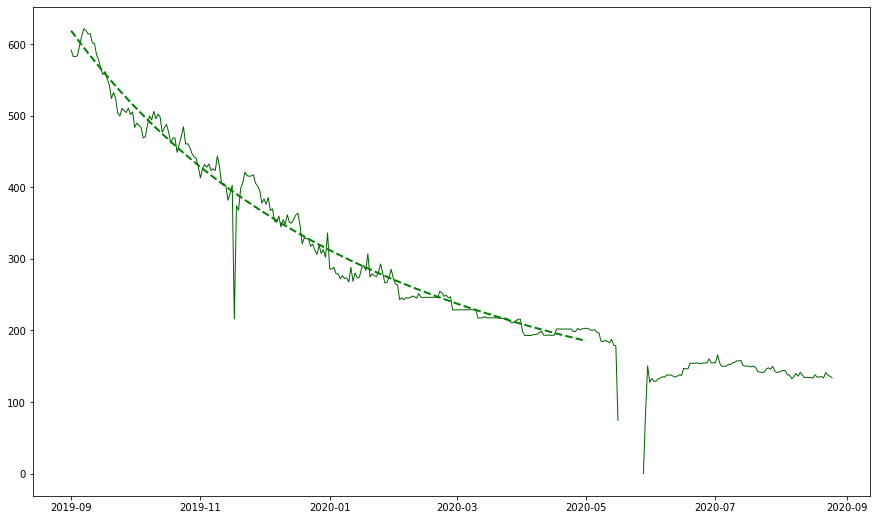

In [13]:
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(prod['date'], prod['bo'], linewidth = 1, color='darkgreen')
ax.plot(f.index, f['rate'], linewidth = 2, linestyle='--', color='green')
#ax.scatter(a['date'],a['bo'],color=(0.1,0.9,0.5),s=155)

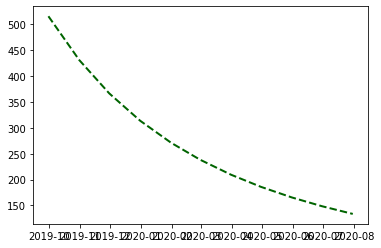

In [14]:
c3.plot()

# Econ Limit

In [15]:
qi = 680 #bbl/d
di = 0.28 #Annual declination in fraction
ti = date(2020,5,1) #Time for initial flow
b = 0
ec = 600


c4 = dc.declination(qi=qi,di=di,ti=ti, econ_limit=ec)
print(c4)

Exponential Declination 
 Ti: 2020-05-01 
 Qi: 680 bbl/d 
 Rate: 0.28 Annually 
 b: 0


In [16]:
c4.forecast(end_date=date(2023,12,31),econ_limit=400)

(              rate        cum
 time                         
 2020-05-31  664.53     664.53
 2020-06-30  649.41   20146.85
 2020-07-31  634.15   39805.48
 2020-08-31  619.25   59002.13
 2020-09-30  605.16   77156.88
 2020-10-31  590.94   95475.92
 2020-11-30  577.49  112800.70
 2020-12-31  563.92  130282.26
 2021-01-31  550.67  147353.00
 2021-02-28  538.97  162444.08
 2021-03-31  526.30  178759.41
 2021-04-30  514.33  194189.23
 2021-05-31  502.24  209758.69
 2021-06-30  490.81  224483.11
 2021-07-31  479.28  239340.79
 2021-08-31  468.02  253849.30
 2021-09-30  457.37  267570.36
 2021-10-31  446.62  281415.60
 2021-11-30  436.46  294509.38
 2021-12-31  426.20  307721.66
 2022-01-31  416.19  320623.45
 2022-02-28  407.34  332029.04,
 332029.04)

In [19]:
qi = 680 #bbl/d
di = 0.28 #Annual declination in fraction
ti = date(2020,5,1) #Time for initial flow
b = 0
ec = 100
npl = 200000

c5 = dc.declination(qi=qi,di=di,ti=ti, econ_limit=ec, np_limit=npl)
print(c5)

Exponential Declination 
 Ti: 2020-05-01 
 Qi: 680 bbl/d 
 Rate: 0.28 Annually 
 b: 0


In [22]:
c5.forecast(fq='5d')

(              rate        cum
 time                         
 2020-05-01  680.00     680.00
 2020-05-06  677.40    4066.98
 2020-05-11  674.80    7441.00
 2020-05-16  672.22   10802.10
 2020-05-21  669.65   14150.34
 ...            ...        ...
 2021-03-07  536.08  187929.61
 2021-03-12  534.03  190599.75
 2021-03-17  531.98  193259.67
 2021-03-22  529.95  195909.41
 2021-03-27  527.92  198549.00
 
 [67 rows x 2 columns],
 198549.0)